# Generating Synthetic Single-Cell RNA-Sequencing Data from Small Pilot Studies using Deep Learning
### Martin Treppner
### 2020-04-24
# Load required packages

In [1]:
using Suppressor   # Suppress unnecessary warnings
@suppress begin

    using Pkg, HTTP, CSV, DataFrames, Random, Distances, 
        UMAP, Clustering, Gadfly, DelimitedFiles, 
        MultivariateStats, Serialization, Cairo, Fontconfig

    # Load single-cell deep Boltzmann machine (scDBM) 
    Pkg.add(PackageSpec(url="https://github.com/MTreppner/scDBM.jl", rev="master"))
    using scDBM

    set_default_plot_size(50cm, 20cm)
    
end

# Download example dataset  

The data consists of 3k PBMCs from a Healthy Donor and is freely available from 10x Genomics. On a unix system, you can uncomment and run the following to download and unpack the data

In [2]:
#mkdir data
#wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

# Read dataset

In [4]:
#@suppress begin
    
    countmatrix = DataFrame(readdlm("C:/Users/treppner/Dropbox/PhD/NB-DBM-Paper/manuscript/data/filtered_gene_bc_matrices/hg19/matrix.mtx"))[4:end,1:3];
    countmatrix = unstack(countmatrix, :x2, :x1, :x3);
    countmatrix = DataFrame(replace!(convert(Matrix, countmatrix), missing=>0))[:,2:end];
    names!(countmatrix, Symbol.(:Gene, 1:size(countmatrix,2)));
    countmatrix = Array{Float64,2}(countmatrix);

#end

┌ Warning: `T` is deprecated, use `nonmissingtype` instead.
│   caller = catvaluetype at array.jl:614 [inlined]
└ @ Core C:\Users\treppner\.julia\packages\CategoricalArrays\xjesC\src\array.jl:614


# Remove low quality genes

Crude reduction of data set size for computational purposes.

In [5]:
countmatrix = countmatrix[:,(mapslices(sum, countmatrix, dims=1) .> 500.0)[:]];

In [6]:
# Sample pilot dataset
Random.seed!(111);
cells = 1000;
random_cells = rand(1:size(countmatrix,1),cells);
pilot_data = countmatrix[random_cells,:];

# Fit scDBM

Set up train and test set.

In [7]:
Random.seed!(101);
data, datatest = splitdata(pilot_data, 0.3);
datadict = DataDict("Training data" => data, "Test data" => datatest);

Set initial parameters.
The learning rate has to be set relatively small, because the reconstruction can get
very large for high expression values. Hence, the corresponding weights will get a very
big learning signal.

In [8]:
epochs = 750;                                    # Train for 750 epochs
init_disp = (ones(size(data,2)) .* 1.0);         # Set inverse dispersion parameter
lr = [0.000001*ones(3500);0.00005*ones(1000)];   # Set learning rate
regularization = 220.0;                          # Set regularization parameter

Train scDBM.

Epoch = 200
Epoch = 400
Epoch = 600
Epoch = 200
Epoch = 400


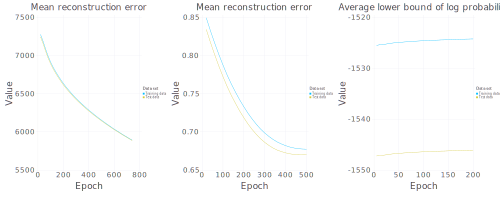

In [9]:
monitor = Monitor(); monitor1 = Monitor(); monitor2 = Monitor();
Random.seed!(59);
dbm = fitdbm(data, epochs = 200, learningrate = 0.0001, batchsizepretraining = 32,
      monitoringdatapretraining = datadict,
      pretraining = [
            # Negative-Binomial RBM
            TrainLayer(nhidden = 12,
            learningrates = lr, 
            epochs = epochs,
            rbmtype = NegativeBinomialBernoulliRBM, 
            inversedispersion = init_disp,
            fisherscoring = 1,
            lambda = regularization,
               monitoring = (rbm, epoch, datadict) -> begin if epoch % 20 == 0 monitorreconstructionerror!(monitor1, rbm, epoch, datadict) end end);
            # Bernoulli RBM
            TrainLayer(nhidden = 4, 
            learningrate = 0.0001,
            epochs = 500,
               monitoring = (rbm, epoch, datadict) -> begin if epoch % 20 == 0 monitorreconstructionerror!(monitor2, rbm, epoch, datadict) end end)
            ];
monitoring = (dbm, epoch) -> begin 
                              if epoch % 5 == 0 
                                 monitorlogproblowerbound!(monitor, dbm, epoch, datadict)
                              end
                           end);
p = hstack(
   plotevaluation(monitor1, monitorreconstructionerror),
   plotevaluation(monitor2, monitorreconstructionerror),
   plotevaluation(monitor, monitorlogproblowerbound)
)
p

Generate synthetic samples.

In [27]:
Random.seed!(559);
number_gensamples = size(pilot_data,1);
synthetic_cells = initparticles(dbm, number_gensamples);
gibbssamplenegativebinomial!(pilot_data,synthetic_cells, dbm, 30);

# Plotting gene distributions

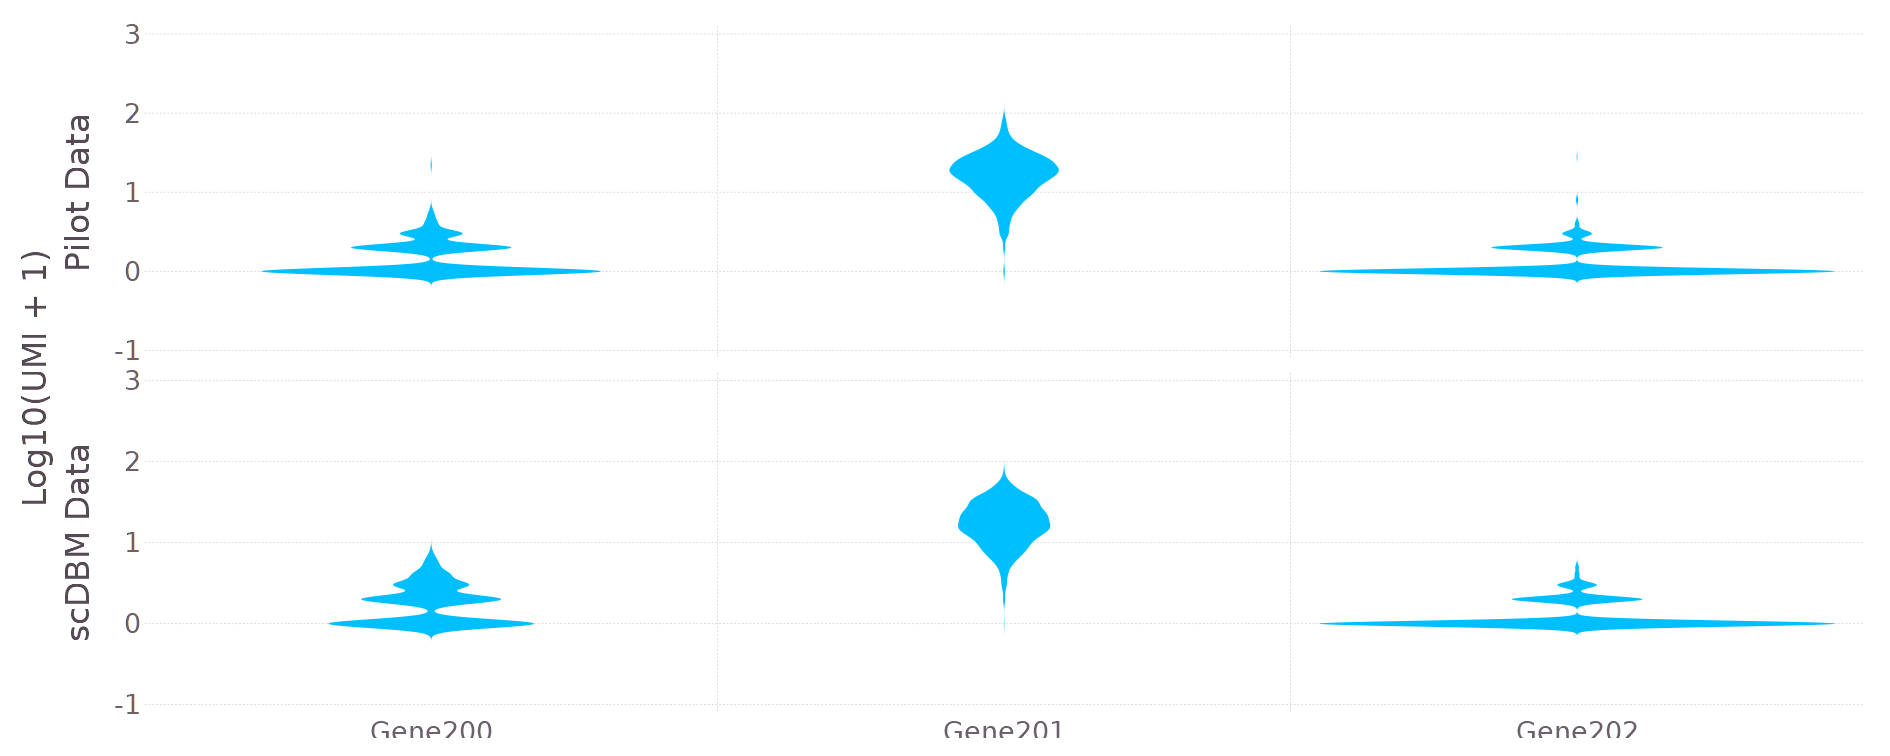

false

In [59]:
# Select genes
genes = [:Gene200, :Gene201, :Gene202];

# Transform pilot data
plot_pilot_data = DataFrame(pilot_data);
names!(plot_pilot_data, Symbol.(:Gene, 1:size(plot_pilot_data,2)));
plot_pilot_data = DataFrames.stack(plot_pilot_data[genes]);
plot_pilot_data[:model] = "Pilot Data";
plot_pilot_data[:log_value] = log10.(plot_pilot_data[:value] .+ 1);

# Transform scDBM data
plot_data_scDBM = DataFrame(synthetic_cells[1]);
names!(plot_data_scDBM, Symbol.(:Gene, 1:size(plot_data_scDBM,2)));
plot_data_scDBM = DataFrames.stack(plot_data_scDBM[genes]);
plot_data_scDBM[:model] = "scDBM Data";
plot_data_scDBM[:log_value] = log10.(plot_data_scDBM[:value] .+ 1);

# Combine data
plot_data = vcat(plot_pilot_data, plot_data_scDBM);

# Violin plot for each gene
p1 = Gadfly.plot(plot_data, ygroup="model", x="variable", y="log_value", 
   Guide.title(""),
   Geom.subplot_grid(Geom.violin),
   Guide.xlabel(""),
   Guide.ylabel("Log10(UMI + 1)"),
   Theme(major_label_font_size=25pt, minor_label_font_size=20pt)
)
p1 |> PNG()

# Dimensionality reduction, clustering, and Davies-Bouldin index

In [22]:
Random.seed!(59);
# PCA and k-means clustering for pilot data
pca_pilot_data = fit(PCA, pilot_data; maxoutdim=10);
counts_clust_original = kmeans(pca_pilot_data.proj', 10);
orig_labels = counts_clust_original.assignments;
pca_original_plot = DataFrame(hcat(pca_pilot_data.proj[:,1],pca_pilot_data.proj[:,2], string.(orig_labels)));
x = ["PC 1", "PC 2", "Cluster"];
names!(pca_original_plot, Symbol.(x));

# Generate number of cells from original dataset (2700 cells) based on scDBM trained on pilot data
number_gensamples = size(countmatrix,1) - size(pilot_data,1);   # Generate remaining number of 
                                                                # cells between pilot and original data
synthetic_cells = initparticles(dbm, number_gensamples);
gibbssamplenegativebinomial!(countmatrix,synthetic_cells, dbm, 30);

# Combiner pilot data and generated data
synthetic_cells = vcat(pilot_data, synthetic_cells[1])

# Map cells using Euclidean distance
maplab(x1,x2,y) = map(arg -> y[findmin(sum((x1 .- x2[arg:arg,:]).^2,dims=2))[2][1]],1:size(x2,1));
scDBM_labels = maplab(pilot_data,synthetic_cells,orig_labels);

# PCA and k-means clustering for scDBM data
pca_scDBM_data = fit(PCA, synthetic_cells; maxoutdim=10);
pca_scDBM_plot = DataFrame(hcat(pca_scDBM_data.proj[:,1],pca_scDBM_data.proj[:,2], string.(scDBM_labels)));
names!(pca_scDBM_plot, Symbol.(x));

orig_dbindex = DBindex(pilot_data, orig_labels);
dbm_dbindex = DBindex(synthetic_cells, scDBM_labels);

println("Original data DBI = ", round(orig_dbindex; digits=4), "\n",  
         "scDBM data DBI = ", round(dbm_dbindex; digits=4))

Original data DBI = 2.4124
scDBM data DBI = 3.1338
